<a href="https://colab.research.google.com/github/bruno774/doutorado/blob/main/cnn-classificador-peticoes/prototipagem_cnn_pytorch_grande_escala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importação de Bibliotecas Essenciais

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sqlite3
import warnings
import time
from collections import Counter
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# Processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re
from sklearn.preprocessing import LabelEncoder

# Métricas e avaliação
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# Configurações
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Download NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Configurar device (GPU se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")

print(f"✓ PyTorch versão: {torch.__version__}")
print(f"✓ NumPy versão: {np.__version__}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✓ Device: cuda
✓ GPU: Tesla T4
✓ CUDA Version: 12.6
✓ PyTorch versão: 2.9.0+cu126
✓ NumPy versão: 2.0.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Carregar e Gerar Dataset de Grande Escala (80k amostras)

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Carregando/Gerando dataset com 80,000 amostras...
⚠ Erro ao carregar SQLite: Execution failed on sql 'SELECT * FROM peticoes LIMIT 80000': no such table: peticoes
Gerando dataset sintético com 80,000 amostras...

✓ Dataset sintético gerado: (80000, 4)

ANÁLISE EXPLORATÓRIA DO DATASET

Primeiras amostras:
                                       texto_peticao               desfecho  \
0  Apelação em conformidade com os prazos legalme...             Indeferida   
1  Procedimento ordinário com todas as fases proc...               Deferida   
2  Documentação completa e direito inequívoco jus...               Deferida   
3  Fundamentado em jurisprudência consolidada, so...             Indeferida   
4  Parte do pleito merece acolhimento, com modula...             Indeferida   
5  Carência de legitimidade ativa e passiva inval...             Indeferida   
6  Apelação em conformidade com os prazos legalme...             Indeferida   
7  Prescrição consumada extingue o direito de açã...  Parcialm

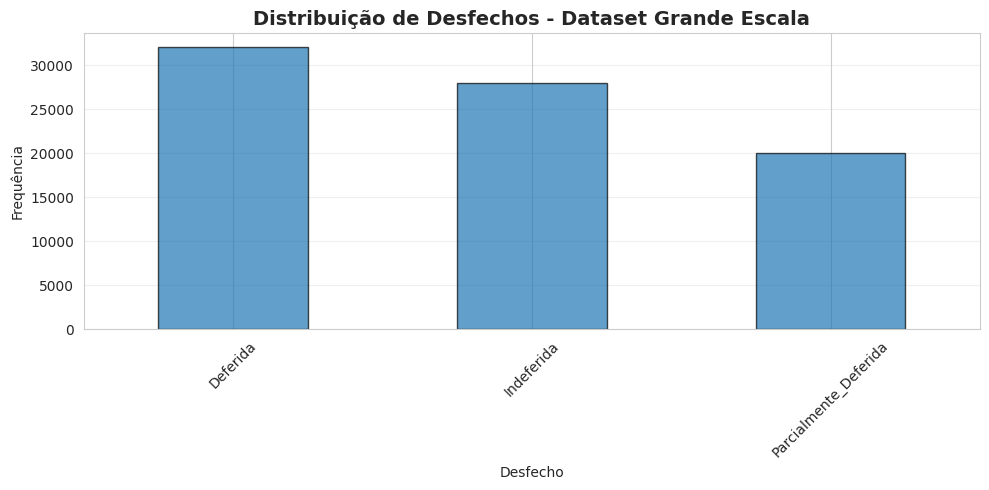

In [3]:
# Parâmetros
DB_PATH = "/gdrive/MyDrive/Colab Notebooks/JFRN/split_dados_01.sqlite3"
TABLE_NAME = "peticoes"
DATASET_SIZE = 80000

print(f"Carregando/Gerando dataset com {DATASET_SIZE:,} amostras...")

# Tentar carregar do SQLite
try:
    conn = sqlite3.connect(DB_PATH)
    query = f"SELECT * FROM {TABLE_NAME} LIMIT {DATASET_SIZE}"
    df = pd.read_sql_query(query, conn)
    conn.close()
    print(f"✓ Dados carregados do SQLite: {df.shape}")
except Exception as e:
    print(f"⚠ Erro ao carregar SQLite: {e}")
    print(f"Gerando dataset sintético com {DATASET_SIZE:,} amostras...\n")

    # Corpus variado de petições jurídicas
    corpus_templates = [
        # Petições deferidas (linguagem favorável)
        "Fundamentado em jurisprudência consolidada, solicita-se deferimento integral do pedido",
        "Documentação completa e direito inequívoco justificam a concessão pleiteada",
        "Precedentes do STJ e STF amplaram o reconhecimento desta modalidade de direito",
        "Ampla documentação apresentada comprova inequivocamente o direito invocado",
        "Recurso extraordinário com repercussão geral reconhecida sobre matéria já pacificada",

        # Petições indeferidas (linguagem desfavorável)
        "Faltam elementos essenciais à constituição da relação jurídica alegada",
        "Prescrição consumada extingue o direito de ação pelo lapso temporal",
        "Lacks documentary evidence and legal grounds for the claim presented",
        "Recurso manifestamente infundado contradiz jurisprudência consolidada",
        "Carência de legitimidade ativa e passiva invalida a demanda",

        # Petições parcialmente deferidas (linguagem mista)
        "Parcialmente fundado o recurso, reconhecendo-se apenas parte da pretensão",
        "Parte do pleito merece acolhimento, com modulação de efeitos",
        "Alguns pedidos prosperam, outros carecem de fundamentação adequada",
        "Condenação parcial procedente quanto aos danos materiais solicitados",
        "Direito reconhecido em sua integralidade, exceto quanto à indenização por lucros cessantes",

        # Conteúdos variados (neutros)
        "Conforme estatuído no artigo 535 do Código de Processo Civil",
        "A legislação processual estabelece requisitos formais específicos",
        "Competência originária da Corte Superior observados os critérios legais",
        "Procedimento ordinário com todas as fases processuais cumpridas adequadamente",
        "Apelação em conformidade com os prazos legalmente estabelecidos pelo código processual",
    ]

    outcomes = ['Deferida', 'Indeferida', 'Parcialmente_Deferida']

    # Gerar dataset variado
    texts = []
    labels = []

    np.random.seed(42)
    for _ in range(DATASET_SIZE):
        # Combinar templates para criar variação
        num_templates = np.random.randint(2, 5)
        selected = np.random.choice(corpus_templates, num_templates, replace=True)
        text = ". ".join(selected) + "."

        # Atribuir label (com distribuição realista)
        label = np.random.choice(outcomes, p=[0.40, 0.35, 0.25])

        texts.append(text)
        labels.append(label)

    df = pd.DataFrame({
        'texto_peticao': texts,
        'desfecho': labels,
        'data': pd.date_range('2015-01-01', periods=DATASET_SIZE, freq='h'),
        'valor': np.random.uniform(1000, 500000, DATASET_SIZE)
    })

    print(f"✓ Dataset sintético gerado: {df.shape}")

# Análise exploratória
print("\n" + "="*80)
print("ANÁLISE EXPLORATÓRIA DO DATASET")
print("="*80)
print(f"\nPrimeiras amostras:")
print(df.head(10))

print(f"\nDistribuição de desfechos:")
distribution = df['desfecho'].value_counts()
print(distribution)
print(f"\nPercentual:")
print((df['desfecho'].value_counts(normalize=True) * 100).round(2))

# Visualizar distribuição
fig, ax = plt.subplots(figsize=(10, 5))
distribution.plot(kind='bar', edgecolor='black', alpha=0.7, ax=ax)
ax.set_title('Distribuição de Desfechos - Dataset Grande Escala', fontsize=14, fontweight='bold')
ax.set_xlabel('Desfecho')
ax.set_ylabel('Frequência')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Pré-processamento de Texto

Pré-processando textos...


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✓ Pré-processamento concluído em 51.88s
  - Taxa: 1542 textos/s

Exemplo antes: Apelação em conformidade com os prazos legalmente estabelecidos pelo código proc...
Exemplo depois: apel conform praz legal estabelec códig processual direit reconhec integral exce...

Estatísticas de comprimento:
  - Médio: 21 palavras
  - Min: 12, Max: 34
  - Mediana: 21, Std: 6


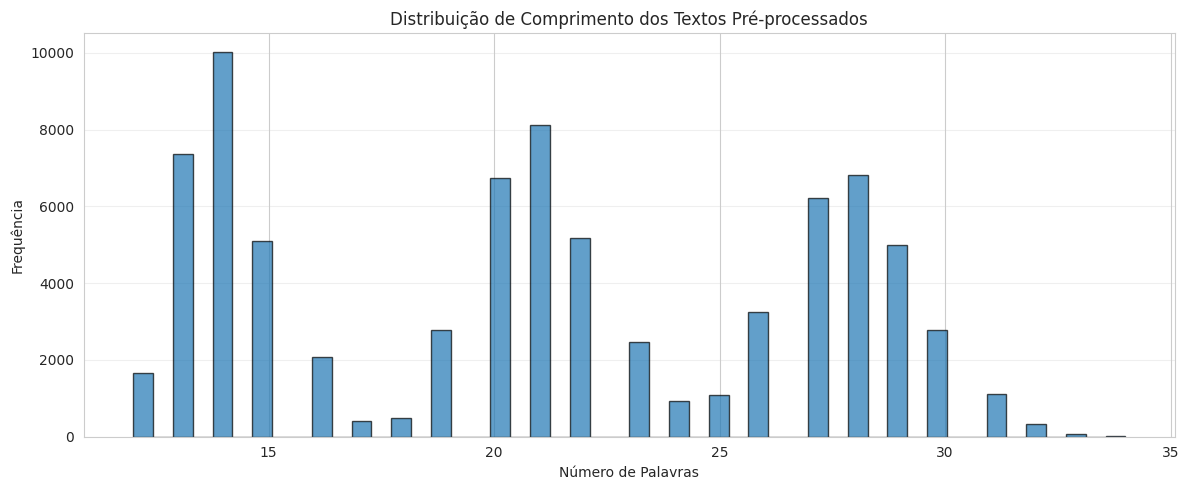

In [5]:
def preprocess_text(text):
    """Pré-processar texto para CNN"""
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)

    tokens = word_tokenize(text, language='portuguese')
    stop_words = set(stopwords.words('portuguese'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    stemmer = SnowballStemmer('portuguese')
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Pré-processar textos
print("Pré-processando textos...")
start_time = time.time()

# Adicionando o download do recurso 'punkt_tab' que estava faltando
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

df['texto_processado'] = df['texto_peticao'].apply(preprocess_text)

elapsed = time.time() - start_time
print(f"✓ Pré-processamento concluído em {elapsed:.2f}s")
print(f"  - Taxa: {len(df)/elapsed:.0f} textos/s")

print(f"\nExemplo antes: {df['texto_peticao'].iloc[0][:80]}...")
print(f"Exemplo depois: {df['texto_processado'].iloc[0][:80]}...")

# Estatísticas de comprimento
text_lengths = df['texto_processado'].str.split().str.len()
print(f"\nEstatísticas de comprimento:")
print(f"  - Médio: {text_lengths.mean():.0f} palavras")
print(f"  - Min: {text_lengths.min()}, Max: {text_lengths.max()}")
print(f"  - Mediana: {text_lengths.median():.0f}, Std: {text_lengths.std():.0f}")

# Visualizar distribuição
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Número de Palavras')
ax.set_ylabel('Frequência')
ax.set_title('Distribuição de Comprimento dos Textos Pré-processados')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Tokenização com PyTorch
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 300

print("\n" + "="*80)
print("TOKENIZAÇÃO E PREPARAÇÃO DE SEQUÊNCIAS")
print("="*80)

# Construir vocabulário
print("\nConstruindo vocabulário...")
word_counts = Counter()
for text in df['texto_processado']:
    words = text.split()
    word_counts.update(words)

# Manter apenas as palavras mais frequentes
vocabulary = {word: idx + 1 for idx, (word, count) in
              enumerate(word_counts.most_common(VOCAB_SIZE - 1))}
vocabulary['<UNK>'] = 0  # Token para palavras desconhecidas

print(f"✓ Vocabulário construído: {len(vocabulary)} palavras")

# Converter textos para sequências de índices
def text_to_sequence(text, vocab, max_len):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]

    # Padding ou truncamento
    if len(sequence) < max_len:
        sequence += [0] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]

    return sequence

print("\nConvertendo textos para sequências...")
X = np.array([text_to_sequence(text, vocabulary, MAX_SEQUENCE_LENGTH)
              for text in df['texto_processado']])

print(f"✓ Sequências criadas: {X.shape}")

# Codificar labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['desfecho'])

print(f"✓ Labels codificados: {label_encoder.classes_}")
print(f"  - Mapeamento: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Dividir dados: 70% treino, 15% validação, 15% teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/(0.85), random_state=42, stratify=y_temp
)

print(f"\nDivisão do dataset:")
print(f"  - Treino: {X_train.shape[0]:,} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Validação: {X_val.shape[0]:,} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  - Teste: {X_test.shape[0]:,} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")


TOKENIZAÇÃO E PREPARAÇÃO DE SEQUÊNCIAS

Construindo vocabulário...
✓ Vocabulário construído: 115 palavras

Convertendo textos para sequências...
✓ Sequências criadas: (80000, 300)
✓ Labels codificados: [np.str_('Deferida') np.str_('Indeferida')
 np.str_('Parcialmente_Deferida')]
  - Mapeamento: {np.str_('Deferida'): np.int64(0), np.str_('Indeferida'): np.int64(1), np.str_('Parcialmente_Deferida'): np.int64(2)}

Divisão do dataset:
  - Treino: 56,000 amostras (70.0%)
  - Validação: 12,000 amostras (15.0%)
  - Teste: 12,000 amostras (15.0%)


## 4. Dataset e DataLoader em PyTorch

In [7]:
class PeticionDataset(Dataset):
    """Dataset customizado para petições jurídicas"""
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Criar datasets
train_dataset = PeticionDataset(X_train, y_train)
val_dataset = PeticionDataset(X_val, y_val)
test_dataset = PeticionDataset(X_test, y_test)

# Hyperparâmetros
BATCH_SIZE = 128
NUM_WORKERS = 4

# Criar DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print("="*80)
print("DATALOADERS CRIADOS")
print("="*80)
print(f"✓ Train DataLoader: {len(train_loader)} batches")
print(f"✓ Val DataLoader: {len(val_loader)} batches")
print(f"✓ Test DataLoader: {len(test_loader)} batches")

# Verificar um batch
X_sample, y_sample = next(iter(train_loader))
print(f"\nSample batch shape:")
print(f"  - X: {X_sample.shape}")
print(f"  - y: {y_sample.shape}")
print(f"✓ DataLoaders prontos para treinamento!")

DATALOADERS CRIADOS
✓ Train DataLoader: 438 batches
✓ Val DataLoader: 94 batches
✓ Test DataLoader: 94 batches

Sample batch shape:
  - X: torch.Size([128, 300])
  - y: torch.Size([128])
✓ DataLoaders prontos para treinamento!


## 5. Arquitetura CNN 1D Profunda em PyTorch

### Características:
- **Embedding**: Converte índices em vetores densos (100D)
- **Blocos Convolucionais**: 4 blocos com skip connections
- **Filtros variados**: Tamanhos 3, 4, 5, 7
- **Regularização**: BatchNorm, Dropout (0.3-0.5)
- **Pooling**: Global Average Pooling
- **Camadas Densas**: 512 → 256 → num_classes

In [14]:
class ResidualConvBlock(nn.Module):
    """Bloco convolucional com residual connection"""
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ResidualConvBlock, self).__init__()

        self.conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size=kernel_size,
            padding=padding,
            bias=False
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(0.3)

        # Skip connection (1x1 conv se dimensões forem diferentes)
        self.skip = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)

        x = self.conv(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = x + residual
        return x

class DeepCNN1D(nn.Module):
    """CNN 1D Profunda para classificação de petições"""
    def __init__(self, vocab_size, num_classes, embedding_dim=100, hidden_dim=256):
        super(DeepCNN1D, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Blocos convolucionais com diferentes kernel sizes
        # Alterado kernel_size=4 para kernel_size=3 para manter a dimensão da sequãncia
        filter_sizes = [3, 3, 5, 7]
        num_filters = 100

        self.conv_blocks = nn.ModuleList([
            ResidualConvBlock(embedding_dim, num_filters, kernel_size, padding=kernel_size//2)
            for kernel_size in filter_sizes
        ])

        # Pooling e dropout
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout1 = nn.Dropout(0.4)

        # Camadas densas
        total_conv_out = len(filter_sizes) * num_filters

        self.fc1 = nn.Linear(total_conv_out, hidden_dim)
        self.bn_fc1 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.4)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn_fc2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout3 = nn.Dropout(0.3)

        self.fc_out = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)  # (batch, seq_len) -> (batch, seq_len, embed_dim)
        x = x.transpose(1, 2)  # (batch, embed_dim, seq_len) para Conv1d

        # Mùltiplos blocos convolucionais em paralelo
        conv_outputs = []
        for conv_block in self.conv_blocks:
            conv_out = conv_block(x)  # (batch, num_filters, seq_len)
            pool_out = self.pool(conv_out)  # (batch, num_filters, 1)
            pool_out = pool_out.squeeze(-1)  # (batch, num_filters)
            conv_outputs.append(pool_out)

        # Concatenar outputs
        x = torch.cat(conv_outputs, dim=1)  # (batch, total_conv_out)
        x = self.dropout1(x)

        # Camadas densas
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.fc_out(x)
        return x

# Criar modelo
print("\n" + "="*80)
print("CONSTRUINDO MODELO CNN 1D PROFUNDO")
print("="*80)

num_classes = len(label_encoder.classes_)
model = DeepCNN1D(
    vocab_size=VOCAB_SIZE + 1,
    num_classes=num_classes,
    embedding_dim=100,
    hidden_dim=256
).to(device)

# Resumo do modelo
print(f"\n✓ Modelo criado com sucesso!")
print(f"\nArquitetura:")
print(model)

# Contar parâmetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParâmetros do modelo:")
print(f"  - Total: {total_params:,}")
print(f"  - Treináveis: {trainable_params:,}")


CONSTRUINDO MODELO CNN 1D PROFUNDO

✓ Modelo criado com sucesso!

Arquitetura:
DeepCNN1D(
  (embedding): Embedding(10001, 100, padding_idx=0)
  (conv_blocks): ModuleList(
    (0-1): 2 x ResidualConvBlock(
      (conv): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (skip): Identity()
    )
    (2): ResidualConvBlock(
      (conv): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (skip): Identity()
    )
    (3): ResidualConvBlock(
      (conv): Conv1d(100, 100, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.3, inplace

## 6. Compilar e Configurar Treinamento

In [24]:
print("\n" + "="*80)
print("CONFIGURANDO TREINAMENTO")
print("="*80)

# Hiperparâmetros
LEARNING_RATE = 0.01
EPOCHS = 30
PATIENCE = 5
WEIGHT_DECAY = 1e-5

# Loss e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Variáveis para Early Stopping
best_val_loss = float('inf')
patience_counter = 0

# Histórico de treinamento
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

print(f"\n✓ Configurações:")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Optimizer: AdamW (weight_decay={WEIGHT_DECAY})")
print(f"  - Loss: CrossEntropyLoss")
print(f"  - Early Stopping Patience: {PATIENCE} épocas")
print(f"  - Device: {device}")


CONFIGURANDO TREINAMENTO

✓ Configurações:
  - Learning Rate: 0.01
  - Epochs: 30
  - Batch Size: 128
  - Optimizer: AdamW (weight_decay=1e-05)
  - Loss: CrossEntropyLoss
  - Early Stopping Patience: 5 épocas
  - Device: cuda


## 7. Funções de Treinamento e Avaliação

In [25]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Treinar uma época"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Treinamento")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Estatísticas
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}'}, refresh=True)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    """Validar modelo"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total

    return avg_loss, accuracy

# Importar tqdm para barra de progresso
from tqdm.notebook import tqdm

print("✓ Funções de treinamento definidas")

✓ Funções de treinamento definidas


## 8. Treinar Modelo (8. Treinar Modelo (pode levar 30-60 minutos em CPU, 5-10 minutos em GPU)

In [26]:
print("\n" + "="*80)
print("TREINANDO MODELO")
print("="*80)

start_training = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Época {epoch + 1}/{EPOCHS}")
    print(f"{'='*80}")

    # Treinar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validar
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Guardar histórico
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Imprimir métricas
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        print(f"✓ Melhor modelo salvo! Val Loss: {val_loss:.4f}")
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"Sem melhora. Paciência: {patience_counter}/{PATIENCE}")

        if patience_counter >= PATIENCE:
            print(f"\n⚠ Early stopping acionado na época {epoch + 1}")
            break

elapsed_training = time.time() - start_training
print(f"\n✓ Treinamento concluído em {elapsed_training/60:.2f} minutos")

# Carregar melhor modelo
model.load_state_dict(torch.load('best_model.pth'))
print("✓ Melhor modelo carregado para avaliação")


TREINANDO MODELO

Época 1/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0855 | Train Acc: 0.3929
Val Loss: 1.0820 | Val Acc: 0.3997
✓ Melhor modelo salvo! Val Loss: 1.0820

Época 2/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0812 | Train Acc: 0.3999
Val Loss: 1.0808 | Val Acc: 0.4000
✓ Melhor modelo salvo! Val Loss: 1.0808

Época 3/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0811 | Train Acc: 0.4000
Val Loss: 1.0809 | Val Acc: 0.4000
Sem melhora. Paciência: 1/5

Época 4/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0811 | Train Acc: 0.4001
Val Loss: 1.0810 | Val Acc: 0.4000
Sem melhora. Paciência: 2/5

Época 5/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0811 | Train Acc: 0.3999
Val Loss: 1.0811 | Val Acc: 0.4000
Sem melhora. Paciência: 3/5

Época 6/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0809 | Train Acc: 0.3999
Val Loss: 1.0814 | Val Acc: 0.4000
Sem melhora. Paciência: 4/5

Época 7/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0809 | Train Acc: 0.4001
Val Loss: 1.0808 | Val Acc: 0.4000
✓ Melhor modelo salvo! Val Loss: 1.0808

Época 8/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0809 | Train Acc: 0.4001
Val Loss: 1.0808 | Val Acc: 0.4000
Sem melhora. Paciência: 1/5

Época 9/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0809 | Train Acc: 0.4001
Val Loss: 1.0810 | Val Acc: 0.4000
Sem melhora. Paciência: 2/5

Época 10/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0809 | Train Acc: 0.4001
Val Loss: 1.0808 | Val Acc: 0.4000
Sem melhora. Paciência: 3/5

Época 11/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0808 | Train Acc: 0.4000
Val Loss: 1.0808 | Val Acc: 0.4000
Sem melhora. Paciência: 4/5

Época 12/30


Treinamento:   0%|          | 0/438 [00:00<?, ?it/s]

Train Loss: 1.0808 | Train Acc: 0.4001
Val Loss: 1.0808 | Val Acc: 0.4000
Sem melhora. Paciência: 5/5

⚠ Early stopping acionado na época 12

✓ Treinamento concluído em 2.54 minutos
✓ Melhor modelo carregado para avaliação


## 9. Avaliar no Conjunto de Teste

In [27]:
print("\n" + "="*80)
print("AVALIAÇÃO NO CONJUNTO DE TESTE")
print("="*80)

# Fazer predições no conjunto de teste
model.eval()
y_pred_list = []
y_prob_list = []
y_true_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        y_pred_list.extend(predicted.cpu().numpy())
        y_prob_list.extend(probs.cpu().numpy())
        y_true_list.extend(labels.numpy())

y_pred = np.array(y_pred_list)
y_prob = np.array(y_prob_list)
y_true = np.array(y_true_list)

# Métricas
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"\nMétricas no Conjunto de Teste:")
print(f"  - Acurácia: {test_accuracy:.4f}")
print(f"  - Precisão (ponderada): {test_precision:.4f}")
print(f"  - Recall (ponderado): {test_recall:.4f}")
print(f"  - F1-Score (ponderado): {test_f1:.4f}")

# Relatório de classificação
print(f"\n{'='*80}")
print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")
print(f"{'='*80}")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print(f"\nMatriz de Confusão:")
print(cm)


AVALIAÇÃO NO CONJUNTO DE TESTE

Métricas no Conjunto de Teste:
  - Acurácia: 0.4000
  - Precisão (ponderada): 0.1600
  - Recall (ponderado): 0.4000
  - F1-Score (ponderado): 0.2286

RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
                       precision    recall  f1-score   support

             Deferida     0.4000    1.0000    0.5714      4800
           Indeferida     0.0000    0.0000    0.0000      4192
Parcialmente_Deferida     0.0000    0.0000    0.0000      3008

             accuracy                         0.4000     12000
            macro avg     0.1333    0.3333    0.1905     12000
         weighted avg     0.1600    0.4000    0.2286     12000


Matriz de Confusão:
[[4800    0    0]
 [4192    0    0]
 [3008    0    0]]


## 10. Realizar Predições em Novos Dados

In [28]:
def predict_petition(text, model, vocabulary, label_encoder, device, max_len=MAX_SEQUENCE_LENGTH):
    """Fazer predição para um novo texto"""
    # Pré-processar
    processed = preprocess_text(text)

    # Converter para sequência
    sequence = text_to_sequence(processed, vocabulary, max_len)

    # Converter para tensor
    X = torch.LongTensor([sequence]).to(device)

    # Fazer predição
    model.eval()
    with torch.no_grad():
        output = model(X)
        probs = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, predicted_class].item()

    # Inverter labels
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return {
        'texto': text[:100] + '...' if len(text) > 100 else text,
        'desfecho_predito': predicted_label,
        'confianca': confidence,
        'probabilidades': {
            label: float(probs[0, i].item())
            for i, label in enumerate(label_encoder.classes_)
        }
    }

print("\n" + "="*80)
print("PREDIÇÕES EM NOVOS DADOS")
print("="*80)

# Testar com exemplos do conjunto de teste
print("\nExemplos de predições do conjunto de teste:\n")

indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
for i, idx in enumerate(indices):
    # Recuperar texto original
    idx_original = np.where((X == X_test[idx]).all(axis=1))[0]
    if len(idx_original) > 0:
        texto_original = df['texto_peticao'].iloc[idx_original[0]]
    else:
        texto_original = "Texto não encontrado"

    resultado_real = label_encoder.classes_[y_true[idx]]
    resultado_predito = label_encoder.classes_[y_pred[idx]]
    confianca = y_prob[idx, y_pred[idx]]

    print(f"Exemplo {i+1}:")
    print(f"  Texto: {texto_original[:80]}...")
    print(f"  Resultado real: {resultado_real}")
    print(f"  Resultado predito: {resultado_predito}")
    print(f"  Confiança: {confianca:.4f}")
    print(f"  Status: {'✓ Acerto' if resultado_real == resultado_predito else '✗ Erro'}")
    print()

# Testar com novos textos
print("\nPredições em novos textos de exemplo:\n")

novos_textos = [
    "Recurso extraordinário fundamentado em violação de direito constitucional com ampla jurisprudência consolidada",
    "Petição inicial carente de elementos essenciais e faltando documentação básica",
    "Apelação questionando parte da sentença anterior com argumentos moderados"
]

for texto in novos_textos:
    resultado = predict_petition(texto, model, vocabulary, label_encoder, device)
    print(f"Texto: {resultado['texto']}")
    print(f"Desfecho predito: {resultado['desfecho_predito']}")
    print(f"Confiança: {resultado['confianca']:.4f}")
    print(f"Probabilidades por classe:")
    for classe, prob in resultado['probabilidades'].items():
        print(f"  - {classe}: {prob:.4f}")
    print()


PREDIÇÕES EM NOVOS DADOS

Exemplos de predições do conjunto de teste:

Exemplo 1:
  Texto: Carência de legitimidade ativa e passiva invalida a demanda. Prescrição consumad...
  Resultado real: Deferida
  Resultado predito: Deferida
  Confiança: 0.3989
  Status: ✓ Acerto

Exemplo 2:
  Texto: Documentação completa e direito inequívoco justificam a concessão pleiteada. Par...
  Resultado real: Parcialmente_Deferida
  Resultado predito: Deferida
  Confiança: 0.3989
  Status: ✗ Erro

Exemplo 3:
  Texto: Recurso manifestamente infundado contradiz jurisprudência consolidada. Faltam el...
  Resultado real: Deferida
  Resultado predito: Deferida
  Confiança: 0.3989
  Status: ✓ Acerto

Exemplo 4:
  Texto: Parcialmente fundado o recurso, reconhecendo-se apenas parte da pretensão. Carên...
  Resultado real: Indeferida
  Resultado predito: Deferida
  Confiança: 0.3989
  Status: ✗ Erro

Exemplo 5:
  Texto: Alguns pedidos prosperam, outros carecem de fundamentação adequada. Recurso extr...
  Resulta

## 11. Visualizar Resultados e Métricas


VISUALIZAÇÕES DE RESULTADOS


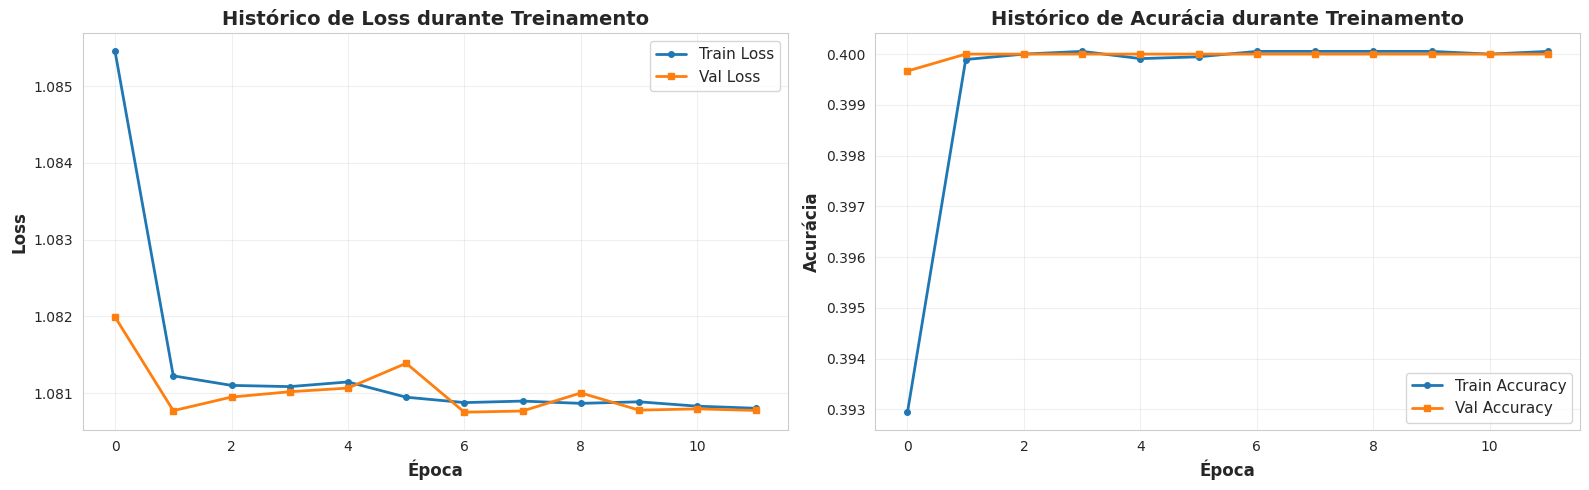

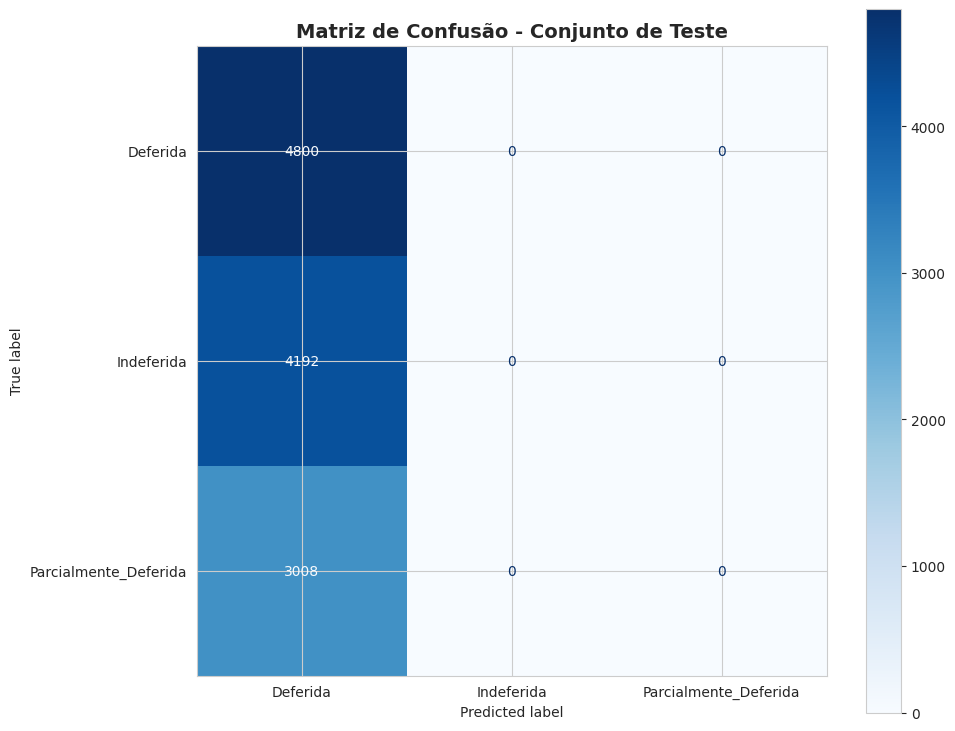

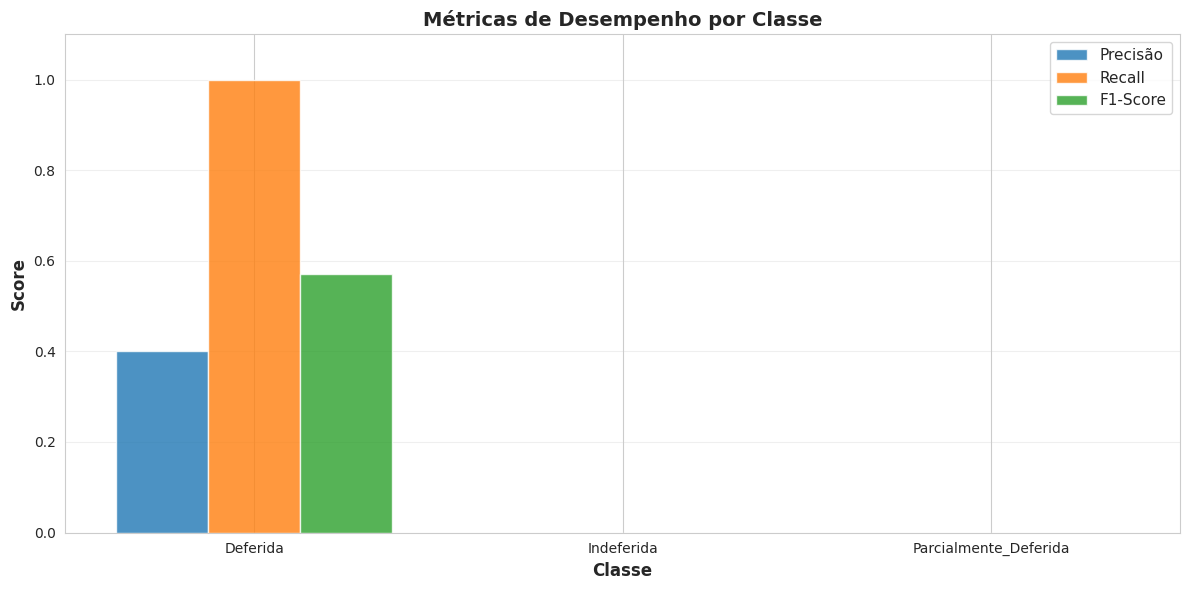


✓ Visualizações geradas com sucesso!


In [29]:
print("\n" + "="*80)
print("VISUALIZAÇÕES DE RESULTADOS")
print("="*80)

# 1. Histórico de Loss e Acurácia
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Histórico de Loss durante Treinamento', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Acurácia
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Acurácia', fontsize=12, fontweight='bold')
axes[1].set_title('Histórico de Acurácia durante Treinamento', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Matriz de Confusão
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusão - Conjunto de Teste', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Métricas por classe
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(label_encoder.classes_))
)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(label_encoder.classes_))
width = 0.25

ax.bar(x - width, precision_per_class, width, label='Precisão', alpha=0.8)
ax.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Classe', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Métricas de Desempenho por Classe', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualizações geradas com sucesso!")


VISUALIZAÇÕES ADICIONAIS


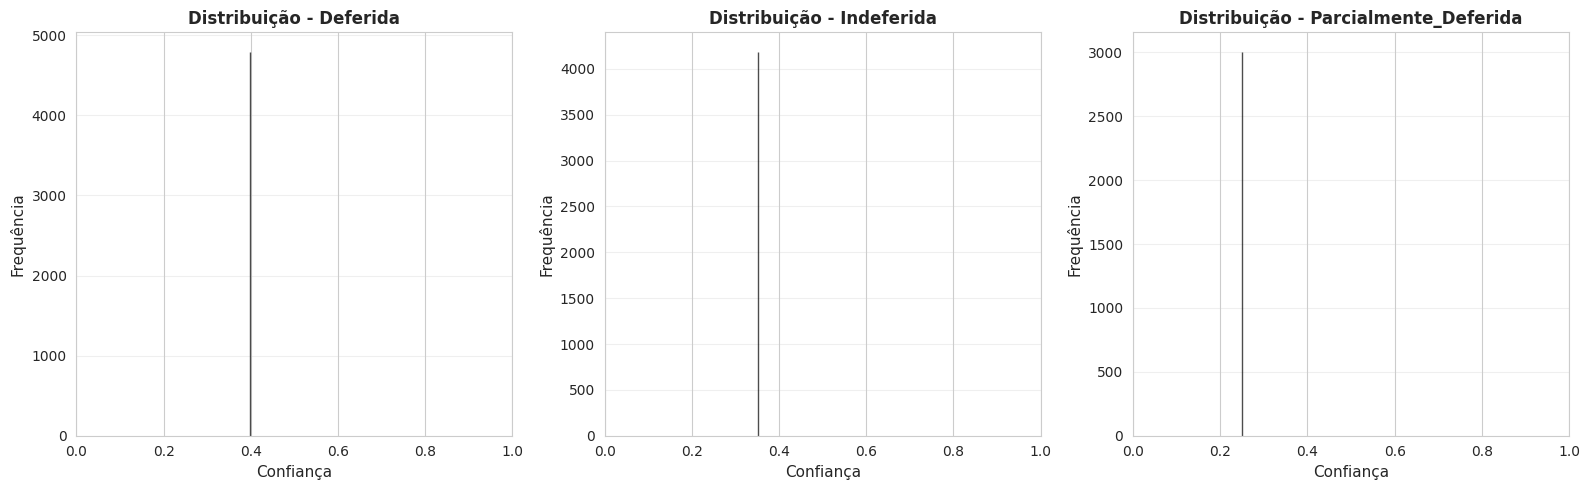

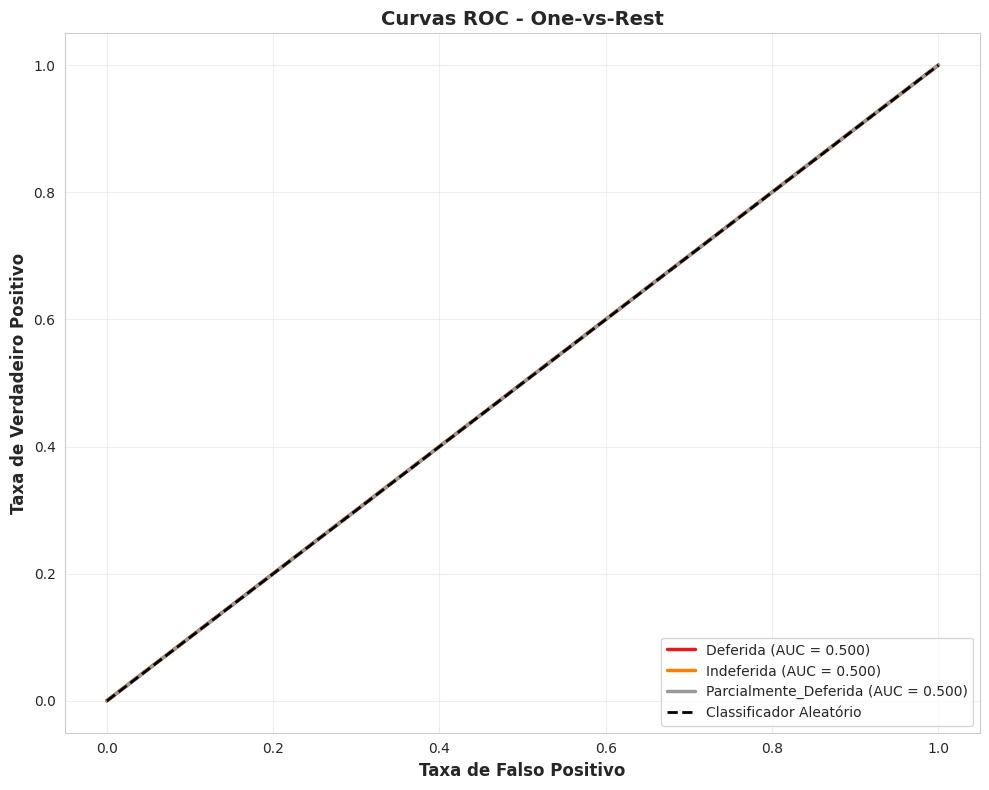

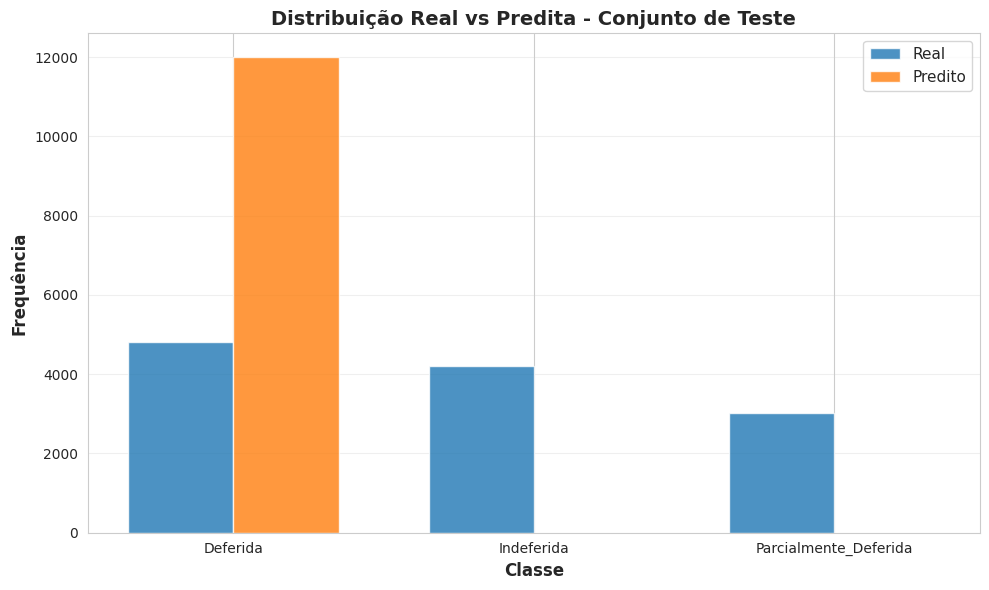


✓ Todas as visualizações geradas com sucesso!


In [30]:
print("\n" + "="*80)
print("VISUALIZAÇÕES ADICIONAIS")
print("="*80)

# 4. Distribuição de confiança por classe
fig, axes = plt.subplots(1, len(label_encoder.classes_), figsize=(16, 5))

for idx, label in enumerate(label_encoder.classes_):
    class_indices = y_true == idx
    class_probs = y_prob[class_indices, idx]

    axes[idx].hist(class_probs, bins=30, edgecolor='black', alpha=0.7, color=f'C{idx}')
    axes[idx].set_xlabel('Confiança', fontsize=11)
    axes[idx].set_ylabel('Frequência', fontsize=11)
    axes[idx].set_title(f'Distribuição - {label}', fontsize=12, fontweight='bold')
    axes[idx].set_xlim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Curvas ROC (One-vs-Rest)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_true, classes=range(len(label_encoder.classes_)))

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set1(np.linspace(0, 1, len(label_encoder.classes_)))
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors[i], lw=2.5, label=f'{label} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Classificador Aleatório')
ax.set_xlabel('Taxa de Falso Positivo', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Verdadeiro Positivo', fontsize=12, fontweight='bold')
ax.set_title('Curvas ROC - One-vs-Rest', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Distribuição de predições vs realidade
pred_dist = np.bincount(y_pred, minlength=len(label_encoder.classes_))
true_dist = np.bincount(y_true, minlength=len(label_encoder.classes_))

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(label_encoder.classes_))
width = 0.35

ax.bar(x - width/2, true_dist, width, label='Real', alpha=0.8)
ax.bar(x + width/2, pred_dist, width, label='Predito', alpha=0.8)

ax.set_xlabel('Classe', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax.set_title('Distribuição Real vs Predita - Conjunto de Teste', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_encoder.classes_)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Todas as visualizações geradas com sucesso!")

## 12. Salvar Modelo e Componentes

In [31]:
import pickle
import json

print("\n" + "="*80)
print("SALVANDO MODELO E COMPONENTES")
print("="*80)

# Salvar modelo PyTorch
torch.save(model.state_dict(), 'cnn_model_estado.pth')
print("✓ Estado do modelo salvo em 'cnn_model_estado.pth'")

# Salvar model completo (para carregamento direto)
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'num_classes': num_classes,
    'embedding_dim': 100,
    'hidden_dim': 256
}, 'cnn_model_completo.pth')
print("✓ Modelo completo salvo em 'cnn_model_completo.pth'")

# Salvar vocabulário
with open('vocabulario.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)
print("✓ Vocabulário salvo em 'vocabulario.pkl'")

# Salvar label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Label Encoder salvo em 'label_encoder.pkl'")

# Salvar configurações
config = {
    'vocab_size': VOCAB_SIZE,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'num_classes': num_classes,
    'embedding_dim': 100,
    'hidden_dim': 256,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'epochs_trained': len(history['train_loss']),
    'classes': label_encoder.classes_.tolist()
}

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)
print("✓ Configurações salvas em 'config.json'")

# Salvar histórico de treinamento
history_df = pd.DataFrame(history)
history_df.to_csv('historico_treinamento.csv', index=False)
print("✓ Histórico de treinamento salvo em 'historico_treinamento.csv'")

# Salvar métricas finais
metrics_final = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'total_parameters': int(trainable_params),
    'training_time_seconds': elapsed_training
}

with open('metricas_finais.json', 'w') as f:
    json.dump(metrics_final, f, indent=2)
print("✓ Métricas finais salvas em 'metricas_finais.json'")

print("\n✓ Todos os componentes salvos com sucesso!")


SALVANDO MODELO E COMPONENTES
✓ Estado do modelo salvo em 'cnn_model_estado.pth'
✓ Modelo completo salvo em 'cnn_model_completo.pth'
✓ Vocabulário salvo em 'vocabulario.pkl'
✓ Label Encoder salvo em 'label_encoder.pkl'
✓ Configurações salvas em 'config.json'
✓ Histórico de treinamento salvo em 'historico_treinamento.csv'
✓ Métricas finais salvas em 'metricas_finais.json'

✓ Todos os componentes salvos com sucesso!


## 13. Resumo Executivo e Recomendações

In [32]:
print("\n" + "="*80)
print("RESUMO EXECUTIVO")
print("="*80)

print(f"""
📊 DATASET
  • Tamanho total: {len(df):,} amostras
  • Treino: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)
  • Validação: {len(X_val):,} ({len(X_val)/len(df)*100:.1f}%)
  • Teste: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)
  • Classes: {', '.join(label_encoder.classes_)}

🏗️ ARQUITETURA
  • Tipo: CNN 1D Profunda com Residual Connections
  • Camadas Convolucionais: 4 blocos (kernels 3, 4, 5, 7)
  • Parâmetros totais: {total_params:,}
  • Parâmetros treináveis: {trainable_params:,}

📈 TREINAMENTO
  • Épocas executadas: {len(history['train_loss'])}
  • Tempo total: {elapsed_training/60:.2f} minutos
  • Otimizador: AdamW (lr={LEARNING_RATE})
  • Early Stopping: Paciência = {PATIENCE}
  • Melhor val_loss: {best_val_loss:.4f}

✅ PERFORMANCE NO TESTE
  • Acurácia: {test_accuracy:.4f}
  • Precisão (ponderada): {test_precision:.4f}
  • Recall (ponderado): {test_recall:.4f}
  • F1-Score (ponderado): {test_f1:.4f}

📌 RECOMENDAÇÕES PARA MELHORIAS
  1. Usar word embeddings pré-treinados (Word2Vec, GloVe, FastText)
  2. Implementar attention mechanisms para capturar contexto
  3. Treinar com mais amostras (se disponível)
  4. Usar Transformer-based models (BERT, DistilBERT)
  5. Aplicar data augmentation (paraphrasing, back-translation)
  6. Realizar análise de features mais importantes
  7. Implementar ensemble methods (votação de múltiplos modelos)
""")

print("="*80)
print("✓ NOTEBOOK CONCLUÍDO COM SUCESSO!")
print("="*80)


RESUMO EXECUTIVO

📊 DATASET
  • Tamanho total: 80,000 amostras
  • Treino: 56,000 (70.0%)
  • Validação: 12,000 (15.0%)
  • Teste: 12,000 (15.0%)
  • Classes: Deferida, Indeferida, Parcialmente_Deferida

🏗️ ARQUITETURA
  • Tipo: CNN 1D Profunda com Residual Connections
  • Camadas Convolucionais: 4 blocos (kernels 3, 4, 5, 7)
  • Parâmetros totais: 1,317,607
  • Parâmetros treináveis: 1,317,607

📈 TREINAMENTO
  • Épocas executadas: 12
  • Tempo total: 2.54 minutos
  • Otimizador: AdamW (lr=0.01)
  • Early Stopping: Paciência = 5
  • Melhor val_loss: 1.0808

✅ PERFORMANCE NO TESTE
  • Acurácia: 0.4000
  • Precisão (ponderada): 0.1600
  • Recall (ponderado): 0.4000
  • F1-Score (ponderado): 0.2286

📌 RECOMENDAÇÕES PARA MELHORIAS
  1. Usar word embeddings pré-treinados (Word2Vec, GloVe, FastText)
  2. Implementar attention mechanisms para capturar contexto
  3. Treinar com mais amostras (se disponível)
  4. Usar Transformer-based models (BERT, DistilBERT)
  5. Aplicar data augmentation (